In [1]:
import torch
from torch import nn
import torchvision
from torchvision import transforms
from matplotlib import pyplot as plt
import numpy as np

## Homework 3 - Regularization and early stopping
*Lorenzo Basile*


In [2]:
trainset = torchvision.datasets.MNIST("./data/", train = True, transform=transforms.ToTensor(), download = False)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
validationset = torchvision.datasets.MNIST("./data/", train = False, transform=transforms.ToTensor(), download = False)
validationloader = torch.utils.data.DataLoader(validationset, batch_size=512, shuffle=True)

In [3]:
class NN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(784, 32),
            nn.ReLU(),
            nn.Dropout(p=.2),
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Dropout(p=.2),
            nn.Linear(64, 10)
        )
    def forward(self, x):
        return (self.layers(x.view(-1,784)))
net=NN()

### 1, 2a
Here the MLP is trained on MNIST dataset using L1 regularization and the simplest kind of early stopping, meaning that training is interrupted as soon as the loss on validation data exceeds by more than $\alpha \%$ the minimum loss up to that epoch. Each time the optimal value is updated, model parameters are saved in order to be able to restore the optimal parameters at the end of training.

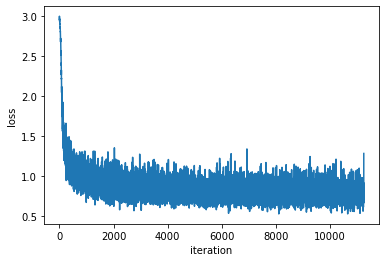

In [4]:
optimizer = torch.optim.SGD(net.parameters(), lr=0.1)
loss = torch.nn.CrossEntropyLoss()
losses=[]
lam=.001
alpha=20
e_opt=float('inf')
for epoch in range(100):
    print("Epoch: ", epoch, '/', 100, end='\r')
    net.train()
    for x, y in trainloader:
        out=net(x)
        l=loss(out, y)
        l1_norm=sum(p.abs().sum() for p in net.parameters())
        losses.append(l)
        l+=lam*l1_norm
        optimizer.zero_grad()
        l.backward()
        optimizer.step()
    e_va=0
    net.eval()
    with torch.no_grad():
        for x, y in validationloader:
            out=net(x)
            e_va+=loss(out, y)
    if e_opt>e_va:
        e_opt=e_va
        torch.save(net.state_dict(), "./models/mnist.pt")
    gl=100*(e_va/e_opt-1)
    if gl>alpha:
        net.load_state_dict(torch.load("./models/mnist.pt"))
        break
plt.plot(losses)
plt.xlabel("iteration")
plt.ylabel("loss")
plt.show()

In [5]:
print("Stopped at epoch: ", epoch)

Stopped at epoch:  11


In [6]:
net.eval()
correct=0
with torch.no_grad():
    for x, y in validationloader:
        out=net(x)
        correct+=(torch.argmax(out, axis=1)==y).sum().item()
print("Accuracy on validation set: ", correct/len(validationset))

Accuracy on validation set:  0.9368


### 2b, 3

Here training is repeated using Correct-Class Quadratic Loss and a different technique for early stopping: validation loss is monitored every $k=5$ epochs and training is stopped as soon as loss increases in $s=3$ consecutive measurements.

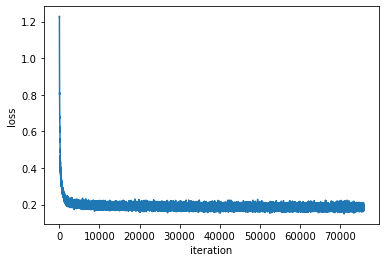

In [7]:
n_classes=10

def CCQL(output, target, w=1):
    encoded_target=nn.functional.one_hot(target, n_classes).float()
    quadratic_loss=nn.MSELoss()
    ql=quadratic_loss(output, encoded_target)/2
    correction=w/2/len(target)*torch.sum(torch.stack([(1-output[i, target[i]])**2 for i in range(len(target))]))
    return ql+correction

net=NN()
optimizer = torch.optim.SGD(net.parameters(), lr=0.1)
loss = CCQL
losses=[]
lam=.001
k=5
s=3
e_va=[]
for epoch in range(100):
    print("Epoch: ", epoch, '/', 100, end='\r')
    net.train()
    for x, y in trainloader:
        out=net(x)
        l=loss(out, y)
        l1_norm=sum(p.abs().sum() for p in net.parameters())
        losses.append(l)
        l+=lam*l1_norm
        optimizer.zero_grad()
        l.backward()
        optimizer.step()
    e_epoch=0
    net.eval()
    with torch.no_grad():
        for x, y in validationloader:
            out=net(x)
            e_epoch+=loss(out, y)
    if epoch%k==0:
        e_va.append(e_epoch)
    if epoch>=k*s and np.all(np.diff(np.array(e_va[-s:]))>=0):
        break
plt.plot(losses)
plt.xlabel("iteration")
plt.ylabel("loss")
plt.show()

In [8]:
print("Stopped at epoch: ", epoch)

Stopped at epoch:  80


In [9]:
net.eval()
correct=0
with torch.no_grad():
    for x, y in validationloader:
        out=net(x)
        correct+=(torch.argmax(out, axis=1)==y).sum().item()
print("Accuracy on validation set: ", correct/len(validationset))

Accuracy on validation set:  0.8617
